In [1]:
import pandas as pd
import numpy as np
import sklearn.linear_model as lm
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn import model_selection
import matplotlib.pyplot as plt
import sys
sys.path.append('../../02450Toolbox_Python/Tools/')
sys.path.append('../../02450Toolbox_Python/Scripts')
from toolbox_02450 import rlr_validate, feature_selector_lr, bmplot

In [2]:
# Load data into dataframe
df = pd.read_csv('Data/housing_clean.csv')

### Regression Part A

In [3]:
# Split non-numerical data apart
ocean_prox = pd.DataFrame(df['ocean_proximity'], columns=['ocean_proximity'])
df_red = df.copy()
df_red.drop('ocean_proximity', axis=1, inplace=True)

In [4]:
# 1. Do one hot encoding for 'ocean proximity'
le = LabelEncoder()
enc = OneHotEncoder(handle_unknown='ignore')

ocean_prox['encodings'] = le.fit_transform(ocean_prox['ocean_proximity'])
enc_df = pd.DataFrame(enc.fit_transform(ocean_prox[['encodings']]).toarray())
encodings = {0: '<1H OCEAN', 1: 'INLAND', 2: 'ISLAND', 3: 'NEAR BAY', 4: 'NEAR OCEAN'}
enc_df.columns = encodings.values()
enc_df.head()

# join dataframes
df_joined = df_red.join(enc_df)

In [5]:
# 1. test prediction accuracy on dataset
def regression(df, X_keys, y_key):
    y = df[y_key].to_numpy()
    X = df[X_keys].to_numpy()
    if len(X.shape) == 1:
        X = X.reshape(-1,1)
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, y, test_size=0.30, random_state=10)
    model = lm.LinearRegression()
    model.fit(X_train, Y_train)
    result = model.score(X_test, Y_test)
    # print("Accuracy: %.2f%%" % (result*100.0))
    return result

In [6]:
# 1. Forward selection with
all_features = df_joined.drop('median_house_value',1).columns
y_feature ='median_house_value'
acc_values = list()
some_features = all_features.to_list()
chosen_features = list()

for i in range(len(all_features)):
    acc_results = list()

    if i == 0:
        for x_features in some_features:
            acc_results.append(regression(df_joined, x_features, y_feature))
        val, idx = max((val, idx) for (idx, val) in enumerate(acc_results))
        chosen_features.append(some_features[idx])
    else:
        for x_features in some_features:
            current_features = chosen_features[:]
            current_features.append(x_features)
            acc_results.append(regression(df_joined, current_features, y_feature))
        val, idx = max((val, idx) for (idx, val) in enumerate(acc_results))
        if val > acc_values[-1]:
            chosen_features.append(some_features[idx])
        else:
            print(f'exclude {some_features[idx]}')
    acc_values.append(val)
    some_features.pop(idx)
print(acc_values)
print(chosen_features)

exclude NEAR OCEAN
exclude <1H OCEAN
[0.4866695416267832, 0.5985954757611587, 0.6537266063149287, 0.667185384361667, 0.6817082873151359, 0.6847152098436016, 0.6849801461917332, 0.6939029969577919, 0.6953901024467416, 0.6958780374703089, 0.6959238007207806, 0.6958226103621088, 0.6958226103621077]
['median_income', 'INLAND', 'population_per_household', 'bedrooms_per_room', 'housing_median_age', 'households', 'longitude', 'latitude', 'rooms_per_household', 'NEAR BAY', 'ISLAND']


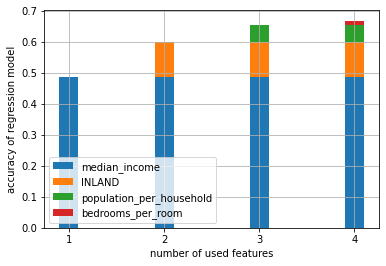

In [42]:
red_values = acc_values[0:4]
dim = len(red_values)
acc_diff = np.zeros(dim)
acc_diff[1:] = np.diff(red_values)
acc_diff[0] = red_values[0]
arr = np.multiply(np.ones((dim,dim)),acc_diff).T
arr = np.triu(arr)
r = np.arange(dim)
for i in range(dim):
    if i == 0:
        plt.bar(r, arr[i,:], width=0.2)
    else:
        temp = np.sum(arr[0:i,:],0)
        plt.bar(r, arr[i,:], bottom=temp, width=0.2)
plt.grid()
plt.legend(chosen_features[0:4])
plt.ylabel('accuracy of regression model')
plt.xlabel('number of used features')
plt.xticks(np.arange(dim), (np.arange(dim)+1))
plt.savefig(f'Plots/feature_contribution.png', dpi = 300)
plt.show()

Cross validation fold 1/5
Train indices: [    0     1     2 ... 20194 20195 20196]
Test indices: [    3    14    17 ... 20189 20193 20197]
Features no: 11

Cross validation fold 2/5
Train indices: [    0     1     2 ... 20194 20195 20197]
Test indices: [    8    11    12 ... 20188 20190 20196]
Features no: 12

Cross validation fold 3/5
Train indices: [    0     2     3 ... 20193 20196 20197]
Test indices: [    1    13    19 ... 20185 20194 20195]
Features no: 12

Cross validation fold 4/5
Train indices: [    0     1     3 ... 20195 20196 20197]
Test indices: [    2     4     5 ... 20169 20173 20174]
Features no: 11

Cross validation fold 5/5
Train indices: [    1     2     3 ... 20195 20196 20197]
Test indices: [    0     6     7 ... 20175 20191 20192]
Features no: 12



Linear regression without feature selection:

- Training error: 3989830724.7703667
- Test error:     3997510175.4534492
- R^2 train:     0.6866881767906032
- R^2 test:     0.6860251044555955
Linear regression with feat

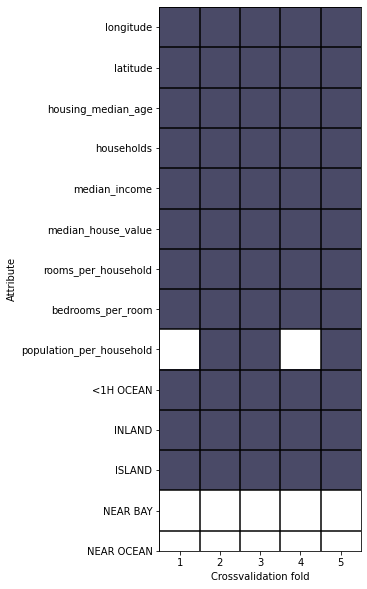

In [47]:
X = df_joined.drop('median_house_value',1).to_numpy()
y = df_joined['median_house_value'].to_numpy()
attributeNames = df_joined.columns
N, M = X.shape

K = 5
CV = model_selection.KFold(n_splits=K,shuffle=True)

# Initialize variables
Features = np.zeros((M,K))
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_fs = np.empty((K,1))
Error_test_fs = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))

k=0
for train_index, test_index in CV.split(X):
    
    # extract training and test set for current CV fold
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]
    internal_cross_validation = 10
    
    # Compute squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum()/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum()/y_test.shape[0]

    # Compute squared error with all features selected (no feature selection)
    m = lm.LinearRegression(fit_intercept=True).fit(X_train, y_train)
    Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Compute squared error with feature subset selection
    textout = ''
    selected_features, features_record, loss_record = feature_selector_lr(X_train, y_train, internal_cross_validation,display=textout)
    
    Features[selected_features,k] = 1
    # .. alternatively you could use module sklearn.feature_selection
    if len(selected_features) is 0:
        print('No features were selected, i.e. the data (X) in the fold cannot describe the outcomes (y).' )
    else:
        m = lm.LinearRegression(fit_intercept=True).fit(X_train[:,selected_features], y_train)
        Error_train_fs[k] = np.square(y_train-m.predict(X_train[:,selected_features])).sum()/y_train.shape[0]
        Error_test_fs[k] = np.square(y_test-m.predict(X_test[:,selected_features])).sum()/y_test.shape[0]

    print('Cross validation fold {0}/{1}'.format(k+1,K))
    print('Train indices: {0}'.format(train_index))
    print('Test indices: {0}'.format(test_index))
    print('Features no: {0}\n'.format(selected_features.size))

    k+=1


# Display results
print('\n')
print('Linear regression without feature selection:\n')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Linear regression with feature selection:\n')
print('- Training error: {0}'.format(Error_train_fs.mean()))
print('- Test error:     {0}'.format(Error_test_fs.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_fs.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test_fs.sum())/Error_test_nofeatures.sum()))

plt.figure(k, figsize=(10,10))
bmplot(attributeNames, range(1,Features.shape[1]+1), -Features)
plt.clim(-1.5,0)
plt.xlabel('Crossvalidation fold')
plt.ylabel('Attribute')
plt.savefig(f'Plots/feature_selection.png', dpi = 300)

# Inspect selected feature coefficients effect on the entire dataset and
# plot the fitted model residual error as function of each attribute to
# inspect for systematic structure in the residual

f=2 # cross-validation fold to inspect
ff=Features[:,f-1].nonzero()[0]
if len(ff) is 0:
    print('\nNo features were selected, i.e. the data (X) in the fold cannot describe the outcomes (y).' )
else:
    m = lm.LinearRegression(fit_intercept=True).fit(X[:,ff], y)
    
    y_est= m.predict(X[:,ff])
    residual=y-y_est
    
plt.show()

In [7]:
# 1. Standardization of all features
scaler = StandardScaler()
df_standardized = pd.DataFrame(scaler.fit_transform(df_joined), columns=df_joined.columns)
df_standardized.round(2)

,longitude,latitude,housing_median_age,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-1.32,1.05,0.99,-1.05,2.65,2.20,1.20,-1.26,-0.49,-0.89,-0.68,-0.02,2.83,-0.38
1,-1.32,1.04,-0.61,1.80,2.63,1.36,0.66,-1.09,-1.10,-0.89,-0.68,-0.02,2.83,-0.38
2,-1.33,1.04,1.86,-0.90,2.02,1.31,2.14,-1.59,-0.15,-0.89,-0.68,-0.02,2.83,-0.38
3,-1.33,1.04,1.86,-0.79,1.08,1.21,0.36,-0.53,-0.50,-0.89,-0.68,-0.02,2.83,-0.38
4,-1.33,1.04,1.86,-0.67,0.02,1.22,0.69,-0.77,-1.00,-0.89,-0.68,-0.02,2.83,-0.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20193,-0.76,1.80,-0.29,-0.47,-1.32,-1.12,-0.20,0.24,-0.48,-0.89,1.47,-0.02,-0.35,-0.38
20194,-0.82,1.80,-0.85,-1.08,-0.73,-1.13,0.57,0.06,0.29,-0.89,1.47,-0.02,-0.35,-0.38
20195,-0.82,1.78,-0.93,-0.18,-1.23,-0.99,-0.09,0.06,-0.80,-0.89,1.47,-0.02,-0.35,-0.38
20196,-0.87,1.78,-0.85,-0.42,-1.14,-1.06,0.00,0.15,-1.08,-0.89,1.47,-0.02,-0.35,-0.38


In [8]:
# Export datasets for use in other notebooks
df_standardized.to_csv('housing_standardized.csv')
df_joined.to_csv('housing_encoded.csv')

In [8]:
# 1. test prediction accuracy on full standardized dataset

y = df_standardized['median_house_value'].to_numpy()
X = df_standardized.copy()
X = X.drop(['median_house_value'], 1).to_numpy()
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, y, test_size=0.30, random_state=10)
model = lm.LinearRegression()
model.fit(X_train, Y_train)
result = model.score(X_test, Y_test)
print("Accuracy: %.2f%%" % (result*100.0))

Accuracy: 69.58%


In [24]:
# 2. evaluate generalization errors

def regularization(dataset, lambda_lb, lambda_ub, file_name):

    """
    Regularization

    TODO:
    estimate generalization error for different values of lambda
    choose a range of values for lambda (error should firs drop than increase)
    use K=10-fold cross-validation
    """

    ## split X and Y
    y = dataset['median_house_value'].to_numpy()
    X = dataset.copy()
    X = X.drop(['median_house_value'], axis=1)
    attributeNames = X.columns.to_list()
    X = X.to_numpy()
    N, M = X.shape

    # Add offset attribute
    X = np.concatenate((np.ones((X.shape[0],1)),X),1)
    attributeNames = [u'Offset']+attributeNames
    M = M+1

    ## Crossvalidation
    # Create crossvalidation partition for evaluation
    K = 5
    CV = model_selection.KFold(K, shuffle=True)
    #CV = model_selection.KFold(K, shuffle=False)

    # Values of lambda
    lambdas = np.power(10.,range(lambda_lb,lambda_ub))

    # Initialize variables
    #T = len(lambdas)
    Error_train = np.empty((K,1))
    Error_test = np.empty((K,1))
    Error_train_rlr = np.empty((K,1))
    Error_test_rlr = np.empty((K,1))
    Error_train_nofeatures = np.empty((K,1))
    Error_test_nofeatures = np.empty((K,1))
    w_rlr = np.empty((M,K))
    mu = np.empty((K, M-1))
    sigma = np.empty((K, M-1))
    w_noreg = np.empty((M,K))

    k=0
    for train_index, test_index in CV.split(X,y):

        # extract training and test set for current CV fold
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        internal_cross_validation = 10    

        opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

        # Standardize outer fold based on training set, and save the mean and standard
        # deviations since they're part of the model (they would be needed for
        # making new predictions) - for brevity we won't always store these in the scripts
        mu[k, :] = np.mean(X_train[:, 1:], 0)
        sigma[k, :] = np.std(X_train[:, 1:], 0)

        X_train[:, 1:] = (X_train[:, 1:] - mu[k, :] ) / sigma[k, :] 
        X_test[:, 1:] = (X_test[:, 1:] - mu[k, :] ) / sigma[k, :] 

        Xty = X_train.T @ y_train
        XtX = X_train.T @ X_train

        # Compute mean squared error without using the input data at all
        Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum(axis=0)/y_train.shape[0]
        Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]

        # Estimate weights for the optimal value of lambda, on entire training set
        lambdaI = opt_lambda * np.eye(M)
        lambdaI[0,0] = 0 # Do no regularize the bias term
        w_rlr[:,k] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
        # Compute mean squared error with regularization with optimal lambda
        Error_train_rlr[k] = np.square(y_train-X_train @ w_rlr[:,k]).sum(axis=0)/y_train.shape[0]
        Error_test_rlr[k] = np.square(y_test-X_test @ w_rlr[:,k]).sum(axis=0)/y_test.shape[0]

        # Estimate weights for unregularized linear regression, on entire training set
        w_noreg[:,k] = np.linalg.solve(XtX,Xty).squeeze()
        # Compute mean squared error without regularization
        Error_train[k] = np.square(y_train-X_train @ w_noreg[:,k]).sum(axis=0)/y_train.shape[0]
        Error_test[k] = np.square(y_test-X_test @ w_noreg[:,k]).sum(axis=0)/y_test.shape[0]
        # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
        #m = lm.LinearRegression().fit(X_train, y_train)
        #Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
        #Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

        # Display the results for the last cross-validation fold
        if k == K-1:
            plt.figure()
            plt.semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'.-') # Don't plot the bias term
            plt.xlabel('Regularization factor')
            plt.ylabel('Mean Coefficient Values')
            plt.grid()
            plt.savefig(f'Plots/mean_coefficient{file_name}.png', dpi = 300)
            # You can choose to display the legend, but it's omitted for a cleaner 
            # plot, since there are many attributes
            #legend(attributeNames[1:], loc='best')
            
            plt.figure()
            plt.title('Optimal lambda: 1e{0}'.format(np.log10(opt_lambda)))
            plt.semilogx(lambdas,train_err_vs_lambda.T,'b.-',lambdas,test_err_vs_lambda.T,'r.--')
            plt.xlabel('Regularization factor')
            plt.ylabel('Squared error (crossvalidation)')
            plt.legend(['Train error','Validation error'])
            plt.grid()
            plt.savefig(f'Plots/lambda_{file_name}.png', dpi = 300)
        # To inspect the used indices, use these print statements
        #print('Cross validation fold {0}/{1}:'.format(k+1,K))
        #print('Train indices: {0}'.format(train_index))
        #print('Test indices: {0}\n'.format(test_index))

        k+=1
    plt.show()
    
    # Display results
    print('Linear regression without feature selection:')
    print('- Training error: {0}'.format(Error_train.mean()))
    print('- Test error:     {0}'.format(Error_test.mean()))
    print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
    print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
    print('Regularized linear regression:')
    print('- Training error: {0}'.format(Error_train_rlr.mean()))
    print('- Test error:     {0}'.format(Error_test_rlr.mean()))
    print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_rlr.sum())/Error_train_nofeatures.sum()))
    print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test_rlr.sum())/Error_test_nofeatures.sum()))

    print('Weights in last fold:')
    plt.figure(figsize=(10,5))
    for m in range(M):
        print('{:>15} {:>15}'.format(attributeNames[m], np.round(w_rlr[m,-1],2)))
    weights = list()
    for m in range(M):
        weights.append(np.round(w_rlr[m,-1],2))
    x = np.arange(M)
    plt.bar(x, weights, width=0.3)
    plt.grid()
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(f'Plots/weights.png', dpi = 300)
    plt.legend(attributeNames)
    plt.show()


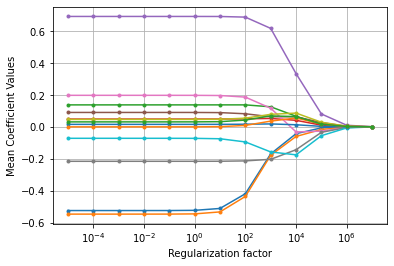

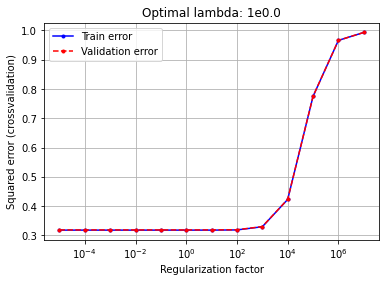

Linear regression without feature selection:
- Training error: 0.3132919587915624
- Test error:     0.3140360059010274
- R^2 train:     0.6867034455119843
- R^2 test:     0.6858902649589478

Regularized linear regression:
- Training error: 0.3132920042359707
- Test error:     0.31403395142799995
- R^2 train:     0.6867034000669093
- R^2 test:     0.685892319914323

Weights in last fold:
         Offset            -0.0
      longitude           -0.52
       latitude           -0.55
housing_median_age            0.14
     households            0.05
  median_income            0.69
rooms_per_household            0.09
bedrooms_per_room             0.2
population_per_household           -0.22
      <1H OCEAN            0.05
         INLAND           -0.07
         ISLAND            0.02
       NEAR BAY            -0.0
     NEAR OCEAN            0.03


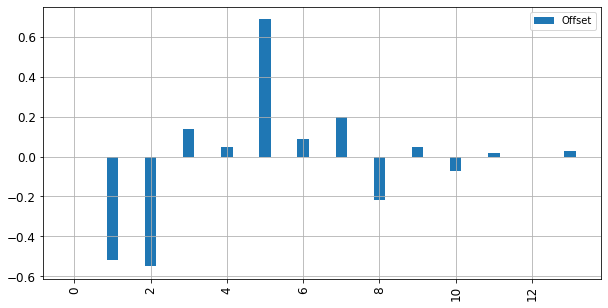

In [30]:
regularization(df_standardized, -5, 8, 'full1')

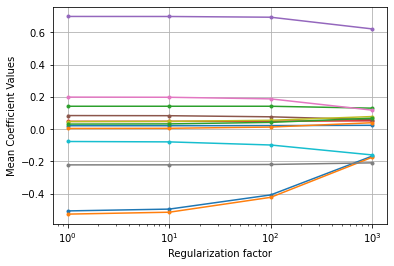

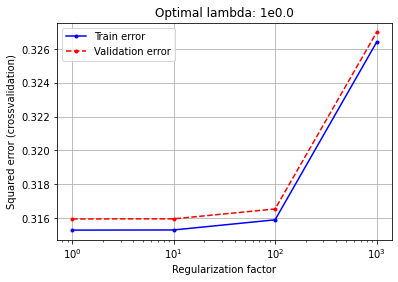

Linear regression without feature selection:
- Training error: 0.3133019679909185
- Test error:     0.3139580727815313
- R^2 train:     0.6866948908673329
- R^2 test:     0.6859915475746658

Regularized linear regression:
- Training error: 0.3133020412007505
- Test error:     0.3139579617538132
- R^2 train:     0.6866948176567669
- R^2 test:     0.6859916586202002

Weights in last fold:
         Offset            0.01
      longitude           -0.51
       latitude           -0.53
housing_median_age            0.14
     households            0.05
  median_income             0.7
rooms_per_household            0.08
bedrooms_per_room             0.2
population_per_household           -0.22
      <1H OCEAN            0.05
         INLAND           -0.08
         ISLAND            0.02
       NEAR BAY             0.0
     NEAR OCEAN            0.03


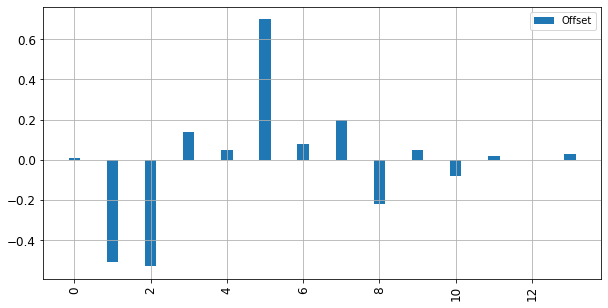

In [31]:
regularization(df_standardized, 0, 4, 'full2')